In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings("ignore", category=UserWarning)

In [19]:
# Colors to show wins vs losses.
color_mapping = {"W":"seagreen",
                 "L":"#C8102E"}

sns.set_style("darkgrid")

In [20]:
playsData = pd.read_csv('../OnlyClippersPlays.csv')
gamesData = pd.read_csv('../ClippersSchedule2425.csv',index_col=0)

In [21]:
playsData

,Unnamed: 0.1,Unnamed: 0,GAME_ID,EVENTMSGTYPE,PERIOD,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN,PLAYED_TIME,LAC_SCORE
0,1,21,22401036,1,1,9:58,Zubac Putback Dunk (2 PTS),NaN,NaN,2 - 2,TIE,0:02:02,2
1,3,23,22401036,1,1,9:30,Zubac 3' Driving Reverse Layup (4 PTS),NaN,NaN,4 - 4,TIE,0:02:30,4
2,5,33,22401036,1,1,7:55,Zubac 7' Driving Hook Shot (6 PTS) (Harden 1 AST),NaN,NaN,7 - 6,-1,0:04:05,6
3,7,35,22401036,1,1,7:16,Dunn 8' Driving Floating Jump Shot (2 PTS) (Ha...,NaN,NaN,9 - 8,-1,0:04:44,8
4,9,40,22401036,1,1,6:26,Dunn 10' Driving Floating Jump Shot (4 PTS) (L...,NaN,NaN,12 - 10,-2,0:05:34,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4143,8785,497,22400071,3,5,2:29,Zubac Free Throw 1 of 2 (20 PTS),NaN,NaN,110 - 107,-3,0:50:31,107
4144,8786,498,22400071,3,5,2:29,Zubac Free Throw 2 of 2 (21 PTS),NaN,NaN,110 - 108,-2,0:50:31,108
4145,8789,507,22400071,1,5,1:40,Jones Jr. 2' Running Finger Roll Layup (12 PTS...,NaN,NaN,112 - 110,-2,0:51:20,110
4146,8792,513,22400071,1,5,1:16,Powell 1' Driving Layup (17 PTS),NaN,NaN,114 - 112,-2,0:51:44,112


In [22]:
# We convert the PLAYED_TIME string column (03:24) into a int column with the seconds played (204)
playsData['PLAYED_TIME'] = pd.to_timedelta(playsData['PLAYED_TIME']).dt.total_seconds()
playsData.head()

,Unnamed: 0.1,Unnamed: 0,GAME_ID,EVENTMSGTYPE,PERIOD,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN,PLAYED_TIME,LAC_SCORE
0,1,21,22401036,1,1,9:58,Zubac Putback Dunk (2 PTS),NaN,NaN,2 - 2,TIE,122.0,2
1,3,23,22401036,1,1,9:30,Zubac 3' Driving Reverse Layup (4 PTS),NaN,NaN,4 - 4,TIE,150.0,4
2,5,33,22401036,1,1,7:55,Zubac 7' Driving Hook Shot (6 PTS) (Harden 1 AST),NaN,NaN,7 - 6,-1,245.0,6
3,7,35,22401036,1,1,7:16,Dunn 8' Driving Floating Jump Shot (2 PTS) (Ha...,NaN,NaN,9 - 8,-1,284.0,8
4,9,40,22401036,1,1,6:26,Dunn 10' Driving Floating Jump Shot (4 PTS) (L...,NaN,NaN,12 - 10,-2,334.0,10


In [23]:
gamesData = gamesData.sort_values('GAME_DATE')

def trackWL(gamesData):
    # Function to track the historic wins and defeats throguh the season after each game. 
    wins, defeats = 0, 0
    winsList,  defeatsList,  pct = [], [], []

    for iGame in range(len(gamesData)):
        if gamesData.iloc[iGame]['WL'] == 'W':
            wins += 1
        else:
            defeats += 1
        winsList.append(wins)
        defeatsList.append(defeats)
        pct.append(wins/(wins+defeats))

    gamesData['WINS'] = winsList
    gamesData['DEFEATS'] = defeatsList
    gamesData['PCT'] = pct
    return gamesData


gamesData = trackWL(gamesData)


months = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

gamesData['GAME_DATE'] = pd.to_datetime(gamesData['GAME_DATE'])
gamesData['GAME_MONTH'] = gamesData['GAME_DATE'].apply(lambda x: months[x.month - 1])


# 1. History of PCT Win during the Season

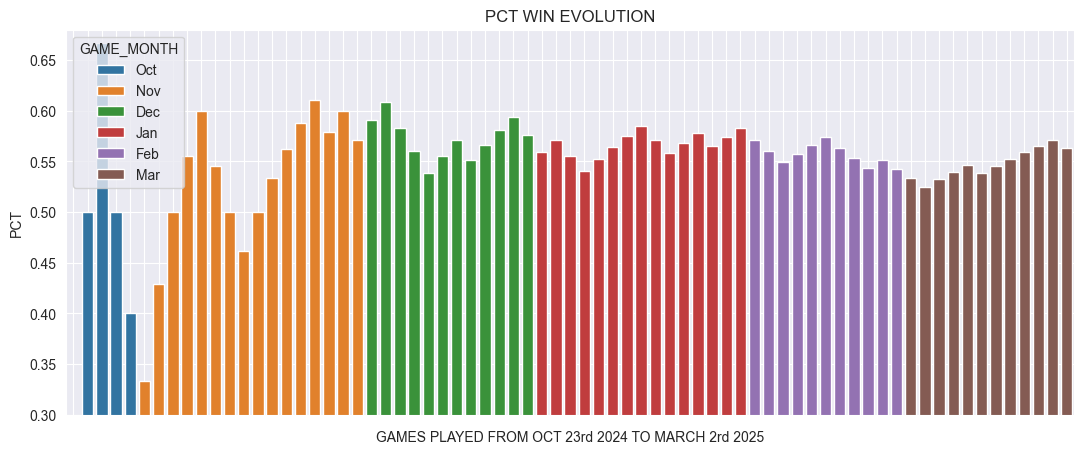

In [24]:
plt.figure(figsize=(13, 5))

sns.barplot(x="GAME_DATE",y="PCT",hue="GAME_MONTH",data=gamesData, legend=True)


plt.ylim(0.3,0.68)
plt.gca().set_xticklabels([])
plt.title('PCT WIN EVOLUTION')
plt.xlabel('GAMES PLAYED FROM OCT 23rd 2024 TO MARCH 2rd 2025')
plt.grid(True)
plt.show()

# 2. Points Scored (Wins vs Losses)

In [25]:
gamesData['GAME_COLOR'] = gamesData['WL'].map(color_mapping)

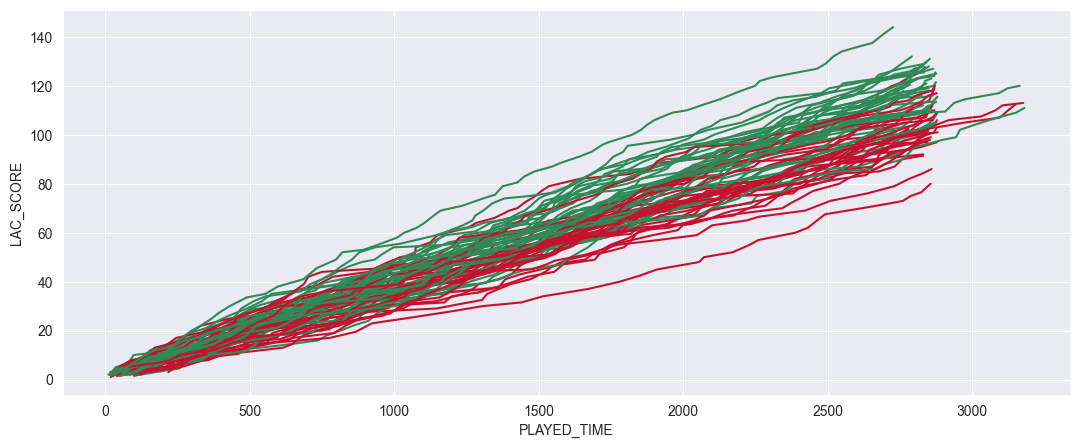

In [26]:
plt.figure(figsize=(13, 5))

game_colors = dict(zip(gamesData['GAME_ID'], gamesData['GAME_COLOR']))

sns.lineplot(playsData, x="PLAYED_TIME",y="LAC_SCORE",hue="GAME_ID", palette=game_colors,legend=False)
plt.grid(True)

In [27]:
def extractPlay(HOME,VISITOR): return VISITOR if pd.isna(HOME) else HOME

playsData['LAC_PLAYS'] = playsData.apply(lambda x: extractPlay(x['HOMEDESCRIPTION'] , x['VISITORDESCRIPTION']),axis=1)
playsData['SCOREMARGIN'] = playsData['SCOREMARGIN'].apply(lambda x: 0 if x=="TIE" else int(x))
HardenSM = playsData[playsData['LAC_PLAYS'].str.split(' ').apply(lambda x: x[0]=='Harden')]
LeonardSM = playsData[playsData['LAC_PLAYS'].str.split(' ').apply(lambda x: x[0]=='Leonard')]
PowellSM = playsData[playsData['LAC_PLAYS'].str.split(' ').apply(lambda x: x[0]=='Powell')]

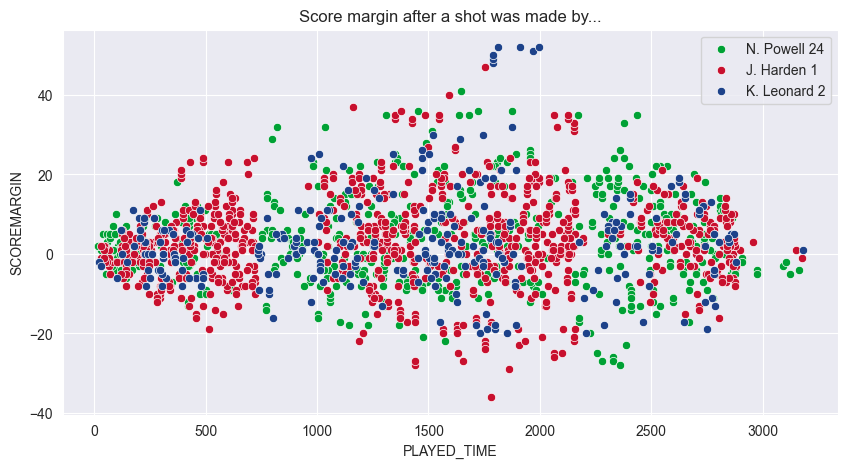

In [28]:
plt.figure(figsize=(10, 5))

sns.scatterplot(data=PowellSM,x="PLAYED_TIME",y="SCOREMARGIN",label="N. Powell 24",color="#00a135")
sns.scatterplot(data=HardenSM,x="PLAYED_TIME",y="SCOREMARGIN",label="J. Harden 1",color="#c8102E")
sns.scatterplot(data=LeonardSM,x="PLAYED_TIME",y="SCOREMARGIN",label="K. Leonard 2",color="#1d428a")
plt.title("Score margin after a shot was made by...")
plt.legend()

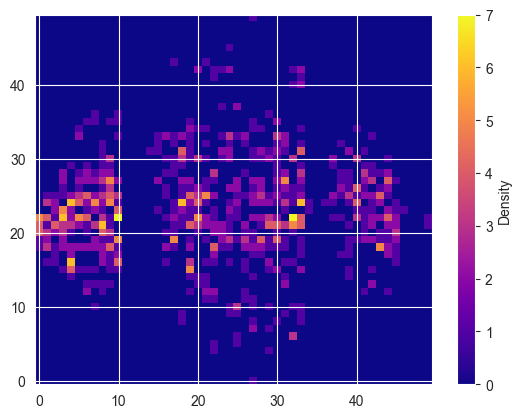

In [29]:
import numpy as np

heatmap, xedges,yedges = np.histogram2d(HardenSM["PLAYED_TIME"],HardenSM["SCOREMARGIN"], bins=50)
plt.imshow(heatmap.T, origin='lower',cmap='plasma',aspect='auto')
plt.colorbar(label='Density')